# SF Parking Citations

### What is the SF Parking Citations dataset?

The SF Parking Citations is a dataset of the parking citations issued by SFMTA. Citation information includes citation, violation and location details which indicate the location and amount of parking citations throughout the city. Citation data is provided by the SFMTA as an export of the citation management system. Citation data is provided daily and the DataSF datasource is updated daily with a 24 hour lag. The geolocation is based on a geocoding process upon load and may not be accurate based on incomplete address data. The dataset is regularly updated daily at [this link](https://data.sfgov.org/Transportation/SFMTA-Parking-Citations/ab4h-6ztd), however, the data used in this EDA was downloaded on June 22, 2022 and is limited to that date. It has citation data dating back to as early as Janurary 2008.

### Why Parking Citations and why this dataset in particular?

Personally, I have a brother who has told me about the numerous amounts of parking citations he has gotten in San Francisco while in the city and how annoying it is to come back to your car to see that you've received a parking citation. No one likes being ticketed and no one enjoys losing money for things you weren't necessarily aware of. I chose the subject of parking citations and this dataset on SF parking citations in particular because I personally am interested in transportation data and it felt like this dataset was quite applicable in my own personal life with helping my brother get less citations whilst also helping people who live in SF or are visiting SF.

## Sections in this EDA

- Cleaning & Preprocessing
- General (nonspecific) EDA
- Time-series trends
- Citation-specific trends
- Street-specific trends

### Purpose

The purpose of this EDA was to gather insights about San Francisco parking citations and the general trends that existed there. This included things such as the types of citations that occurred, where they occurred, etc. My goal with this project is to gather insights about the trends in SF parking citations, summarize them, and report them in an non-technical way that would allow SF residents/visitors to get not only less parking citations, but an overall better understanding of the citations that happen in the city.

In [1]:
# import libraries
import pandas as pd
import numpy as np
from datetime import datetime
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

# Basic Cleaning

In [2]:
cols = ['Citation Issued DateTime', 'Violation', 'Violation Description', 'Citation Location', 'Fine Amount', 'Date Added', 'geom', 'Neighborhoods']
citations = pd.read_csv('SFMTA_-_Parking_Citations.csv', usecols=cols, dtype={'Violation': 'category',
                                                                'Vehicle Plate State': 'category',
                                                                'Fine Amount': 'float16',
                                                                'Neighborhoods': 'category',
                                                                'SF Find Neighborhoods': 'category',
                                                                'Current Police Districts': 'category',
                                                                'Current Supervisor Districts': 'category',
                                                                'Analysis Neighborhoods': 'category'})
citations.head()

,Citation Issued DateTime,Violation,Violation Description,Citation Location,Fine Amount,Date Added,geom,Neighborhoods
0,10/27/2009 03:36:00 PM,T32A.1,TWAWY ZN#1,669 MISSION ST,83.0,10/27/2009 12:00:00 AM,POINT (-122.40131583199997 37.78670342300006),32
1,09/14/2009 11:05:00 AM,V5204A,REG TABS,7 GROVE ST,63.0,09/14/2009 12:00:00 AM,POINT (-122.41511664599994 37.77876024500006),21
2,09/10/2009 03:30:00 PM,T202,PRK METER,2851 24TH ST,53.0,09/10/2009 12:00:00 AM,POINT (-122.40919778399996 37.752743407000025),53
3,09/07/2009 03:21:00 PM,T202,PRK METER,417 BAY ST,53.0,09/07/2009 12:00:00 AM,POINT (-122.41413599899994 37.80540600300003),106
4,09/09/2009 01:23:00 PM,T58A,BLK WHEELS,136 LAWTON ST,48.0,09/09/2009 12:00:00 AM,POINT (-122.46446999799997 37.75869600400006),109


In [3]:
# Gets the neighborhoods unique to SF
neighborhoods = pd.read_csv('SFFind_Neighborhoods.csv')
neighborhoods.head()

,LINK,the_geom,name
0,"http://en.wikipedia.org/wiki/Sea_Cliff,_San_Fr...",MULTIPOLYGON (((-122.49345526799993 37.7835181...,Seacliff
1,NaN,MULTIPOLYGON (((-122.48715071499993 37.7837854...,Lake Street
2,http://www.nps.gov/prsf/index.htm,MULTIPOLYGON (((-122.47758017099994 37.8109931...,Presidio National Park
3,NaN,MULTIPOLYGON (((-122.47241052999993 37.7873465...,Presidio Terrace
4,http://www.sfgate.com/neighborhoods/sf/innerri...,MULTIPOLYGON (((-122.47262578999994 37.7863148...,Inner Richmond


In [4]:
# Look for missing data
citations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18556039 entries, 0 to 18556038
Data columns (total 8 columns):
 #   Column                    Dtype   
---  ------                    -----   
 0   Citation Issued DateTime  object  
 1   Violation                 category
 2   Violation Description     object  
 3   Citation Location         object  
 4   Fine Amount               float16 
 5   Date Added                object  
 6   geom                      object  
 7   Neighborhoods             category
dtypes: category(2), float16(1), object(5)
memory usage: 796.4+ MB


In [5]:
# Find the percent of missing values for each column
null_pct = {col: citations[col].isna().sum() / citations.shape[0] for col in citations.columns}
null_pct

{'Citation Issued DateTime': 0.0,
 'Violation': 5.653146126713789e-05,
 'Violation Description': 5.663924289014482e-05,
 'Citation Location': 0.007596664352774857,
 'Fine Amount': 0.0003730860880385086,
 'Date Added': 0.0,
 'geom': 0.28016194619983287,
 'Neighborhoods': 0.2957565997786489}

In [6]:
# Look at the # of unique violations
print('Number of unique Violations:', citations['Violation'].nunique())
print('Number of unique Violation Description:', citations['Violation Description'].nunique())

Number of unique Violations: 305
Number of unique Violation Description: 255


In [7]:
# Get list of street names in SF
from bs4 import BeautifulSoup
import requests

sf_streets = requests.get('https://geographic.org/streetview/usa/ca/san_francisco.html')

soup = BeautifulSoup(sf_streets.text, 'html.parser')

all_sf_streets = np.array([street.text for street in soup.find_all('li')])

In [8]:
# Data Cleaning

# Convert the datetime columns into datetime (Citation Issued DateTime, Date Added)
citations['Citation Issued DateTime'] =  pd.to_datetime(citations['Citation Issued DateTime'], format='%m/%d/%Y %I:%M:%S %p',infer_datetime_format=True)
citations['Date Added'] = pd.to_datetime(citations['Date Added'], format='%m/%d/%Y %I:%M:%S %p',infer_datetime_format=True)

# Use only the rows with official street names (e.g are in the list of official SF street names)
all_sf_streets = np.char.lower(all_sf_streets)
citations = citations[citations['Citation Location'].str.lower().str.split(' ', 1).str[1].isin(all_sf_streets)]

# Create a column for street names specifically
citations['street_name'] = citations['Citation Location'].str.lower().str.split(' ', 1).str[1]

# Adding hour to look into hour trends
citations['hour'] = citations['Citation Issued DateTime'].dt.hour

# Course of action: don't use these rows in generating heatmap, but do use their data on what type of citation they are/fine amounts

In [9]:
# Merge Neighborhoods with Citations dataset
citations['Neighborhoods'] = citations['Neighborhoods'].astype('float16')
citations = citations.merge(neighborhoods, how = 'left', left_on='Neighborhoods', right_index=True)
citations['Neighborhoods'] = citations['Neighborhoods'].astype('category')

In [10]:
# Dropping irrelevant columns
citations = citations.drop(columns=['LINK', 'the_geom'])

In [11]:
# New dataframe
citations.head()

,Citation Issued DateTime,Violation,Violation Description,Citation Location,Fine Amount,Date Added,geom,Neighborhoods,street_name,hour,name
0,2009-10-27 15:36:00,T32A.1,TWAWY ZN#1,669 MISSION ST,83.0,2009-10-27,POINT (-122.40131583199997 37.78670342300006),32.0,mission st,15,Showplace Square
1,2009-09-14 11:05:00,V5204A,REG TABS,7 GROVE ST,63.0,2009-09-14,POINT (-122.41511664599994 37.77876024500006),21.0,grove st,11,Hayes Valley
2,2009-09-10 15:30:00,T202,PRK METER,2851 24TH ST,53.0,2009-09-10,POINT (-122.40919778399996 37.752743407000025),53.0,24th st,15,Potrero Hill
3,2009-09-07 15:21:00,T202,PRK METER,417 BAY ST,53.0,2009-09-07,POINT (-122.41413599899994 37.80540600300003),106.0,bay st,15,Russian Hill
4,2009-09-09 13:23:00,T58A,BLK WHEELS,136 LAWTON ST,48.0,2009-09-09,POINT (-122.46446999799997 37.75869600400006),109.0,lawton st,13,Parnassus Heights


# General EDA

In [12]:
# Looking at numerical values
citations.describe()

,Fine Amount,hour
count,15347413.0,1.534843e+07
mean,NaN,1.095811e+01
std,NaN,4.092883e+00
min,0.0,0.000000e+00
25%,62.0,9.000000e+00
50%,71.0,1.100000e+01
75%,84.0,1.300000e+01
max,4876.0,2.300000e+01


Text(0.5, 1.0, 'Neighborhoods with Highest Avg. Fine Amount')

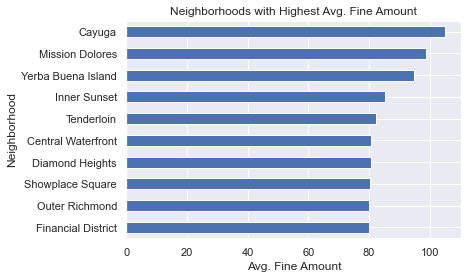

In [13]:
# Looks at the highest avg. fine amount of each neighborhood, sorted in descending order
citations.groupby('name').mean().sort_values(by='Fine Amount')['Fine Amount'].iloc[-10:].plot(kind='barh')
plt.xlabel('Avg. Fine Amount')
plt.ylabel('Neighborhood')
plt.title('Neighborhoods with Highest Avg. Fine Amount')

Text(0.5, 1.0, 'Counts of Total Citations by Date')

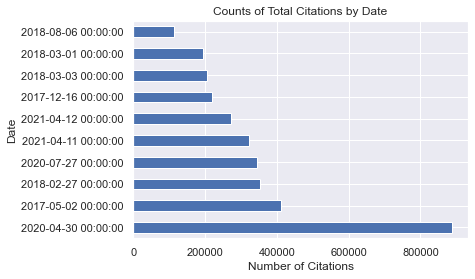

In [14]:
#Gets the count of citations on each day
citations.groupby('Date Added').count()['Violation'].nlargest(10).plot(kind='barh')
plt.ylabel('Date')
plt.xlabel('Number of Citations')
plt.title('Counts of Total Citations by Date')

Text(0.5, 1.0, 'Citations by Fine Amount')

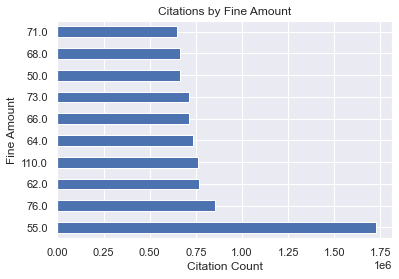

In [15]:
citations['Fine Amount'].value_counts().nlargest(10).plot(kind='barh')
plt.xlabel('Citation Count')
plt.ylabel('Fine Amount')
plt.title('Citations by Fine Amount')

Text(0.5, 1.0, 'Overall number of citations by year')

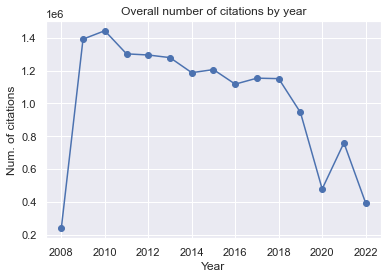

In [52]:
citations['Citation Issued DateTime'].dt.year.value_counts().sort_index().plot(marker='o')
plt.xlabel('Year')
plt.ylabel('Num. of citations')
plt.title('Overall number of citations by year')

# Looking at time-series trends

### Graph of the num. of citations that occur at every hour

Text(0.5, 1.0, 'Total number of citations by hour')

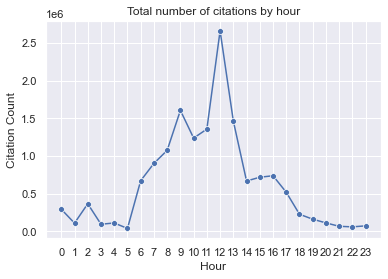

In [17]:
hour_counts = pd.DataFrame(citations['Citation Issued DateTime'].dt.hour.value_counts().sort_index()).reset_index()
hour_counts = hour_counts.rename(columns={'index': 'Hour', 'Citation Issued DateTime': 'Citation Count'})
sns.set_style('darkgrid')
plt.xticks(range(0,24))
sns.lineplot(x='Hour', y='Citation Count', palette='green', marker='o', data=hour_counts)
plt.title('Total number of citations by hour')

### Graph of the num. of citations by month

Text(0.5, 1.0, 'Total number of citations by month')

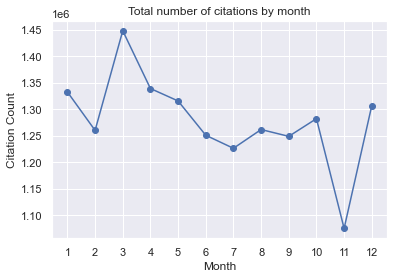

In [18]:
(citations['Citation Issued DateTime'].dt.month.value_counts().sort_index()).plot(marker='o')
plt.xticks(range(1, 13))
plt.xlabel('Month')
plt.ylabel('Citation Count')
plt.title('Total number of citations by month')

### Num. of citations by day of the week

Text(0.5, 1.0, 'Citations by Day')

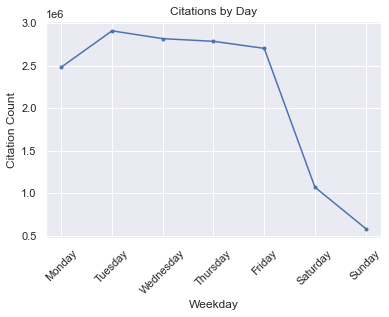

In [19]:
# Plot shows no general trend between the day of the week vs. getting a citation 
(citations['Citation Issued DateTime'].dt.day_name().value_counts())[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].plot(marker='.')
plt.xticks(rotation=45)
plt.xlabel('Weekday')
plt.ylabel('Citation Count')
plt.title('Citations by Day')

Looking at these 3 graphs, we notice that there seems to be a general trend on both the monthly and hourly graphs in which there are certain times in which citations are more likely to occur. This doesn't seem to be the case with weekdays due to the fact that it intuitively makes sense that there is less citations on the weekend (less people in the city). These trends are explored further in the next sections in which I looked at more granular details regarding citations.

# Citation specific trends (e.g Street Cleaning, Parking Meters, etc.)

In [20]:
# Top 10 types of parking citations
# Notice that it falls into 3 major kinds of citations: Street Cleaning, Parking Meter, and Residential
# Let's clean our data so that it reflects this
citations['Violation Description'].value_counts().nlargest(10)

STR CLEAN     3859823
ST CLEANIN    2230995
PRK METER     1181987
MTR OUT DT    1139091
RES/OT         940705
RESIDENTL      714179
PRK MTR #1     518684
METER DTN      477405
REG TABS       415612
DRIVEWAY       299795
Name: Violation Description, dtype: int64

In [21]:
replace_dict = {'ST CLEANIN': 'STR CLEAN', 'MTR OUT DT': 'PRK METER', 'RES/OT': 'RESIDENTIAL', 'RESIDENTL': 'RESIDENTIAL', 'PRK MTR #1': 'PRK METER', 'METER DTN': 'PRK METER'}
citations = citations.replace({'Violation Description': replace_dict})

### Street Cleaning citations

Text(0.5, 1.0, 'Street Cleaning citations by hour')

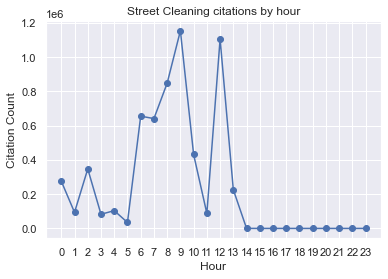

In [22]:
# Look at street cleaning times, see if it differs from the overall times
citations[citations['Violation Description'] == 'STR CLEAN']['Citation Issued DateTime'].dt.hour.value_counts().sort_index().plot(marker='o')
plt.xticks(range(0,24))
plt.xlabel('Hour')
plt.ylabel('Citation Count')
plt.title('Street Cleaning citations by hour')

In [23]:
# Top 10 times for getting a street cleaning violation
citations[citations['Violation Description'] == 'STR CLEAN']['Citation Issued DateTime'].dt.hour.value_counts()[:10]

9     1154661
12    1106192
8      848495
6      655719
7      641564
10     431777
2      347481
0      275912
13     225969
4      103811
Name: Citation Issued DateTime, dtype: int64

Text(0.5, 1.0, 'Overall number of citations by year (Street Cleaning)')

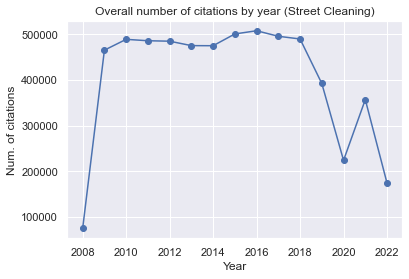

In [47]:
citations[citations['Violation Description'] == 'STR CLEAN']['Citation Issued DateTime'].dt.year.value_counts().sort_index().plot(marker='o')
plt.xlabel('Year')
plt.ylabel('Num. of citations')
plt.title('Overall number of citations by year (Street Cleaning)')

### Parking Meter citations

Text(0.5, 1.0, 'Parking Meter citations by hour')

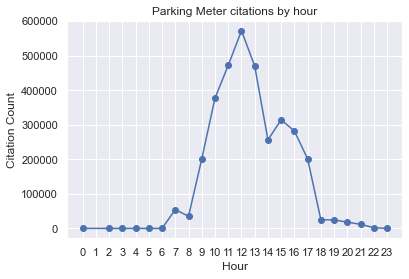

In [24]:
# Look at Parking meter times
citations[citations['Violation Description'] == 'PRK METER']['Citation Issued DateTime'].dt.hour.value_counts().sort_index().plot(marker='o')
plt.xticks(range(0,24))
plt.xlabel('Hour')
plt.ylabel('Citation Count')
plt.title('Parking Meter citations by hour')

In [25]:
# Top 10 times for getting a parking meter violation
citations[citations['Violation Description'] == 'PRK METER']['Citation Issued DateTime'].dt.hour.value_counts()[:10]

12    571954
11    471839
13    470054
10    377177
15    314348
16    281688
14    256192
17    201137
9     201035
7      54573
Name: Citation Issued DateTime, dtype: int64

Text(0.5, 1.0, 'Overall number of citations by year (Parking Meter)')

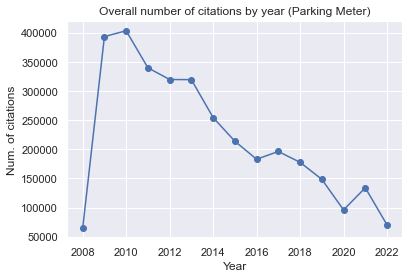

In [51]:
citations[citations['Violation Description'] == 'PRK METER']['Citation Issued DateTime'].dt.year.value_counts().sort_index().plot(marker='o')
plt.xlabel('Year')
plt.ylabel('Num. of citations')
plt.title('Overall number of citations by year (Parking Meter)')

### Residential Citations

Text(0.5, 1.0, 'Residential Parking citations by hour')

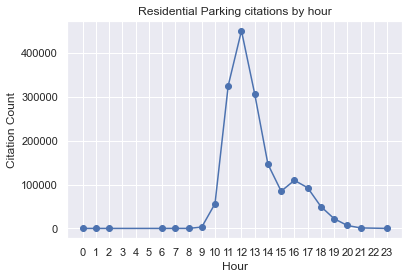

In [26]:
citations[citations['Violation Description'] == 'RESIDENTIAL']['Citation Issued DateTime'].dt.hour.value_counts().sort_index().plot(marker='o')
plt.xticks(range(0,24))
plt.xlabel('Hour')
plt.ylabel('Citation Count')
plt.title('Residential Parking citations by hour')

In [27]:
citations[citations['Violation Description'] == 'RESIDENTIAL']['Citation Issued DateTime'].dt.hour.value_counts()[:10]

12    450285
11    325477
13    306392
14    146286
16    109481
17     92726
15     84805
10     56373
18     49860
19     22231
Name: Citation Issued DateTime, dtype: int64

Text(0.5, 1.0, 'Overall number of citations by year (Residential)')

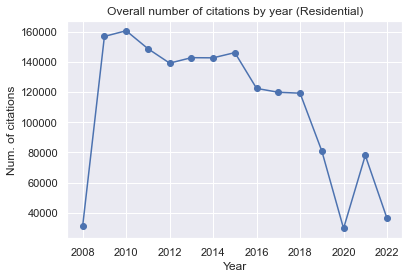

In [50]:
citations[citations['Violation Description'] == 'RESIDENTIAL']['Citation Issued DateTime'].dt.year.value_counts().sort_index().plot(marker='o')
plt.xlabel('Year')
plt.ylabel('Num. of citations')
plt.title('Overall number of citations by year (Residential)')

### Plot of all 3 types of citations at once

Text(0.5, 1.0, 'Top 3 parking citations by hour')

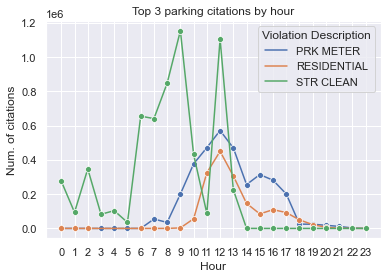

In [28]:
types_of_cit = ['PRK METER', 'STR CLEAN', 'RESIDENTIAL']
df = citations[citations['Violation Description'].isin(types_of_cit)][['Violation Description', 'hour']].groupby('Violation Description').value_counts().reset_index()
sns.lineplot(x='hour', y=0, hue='Violation Description', data=df, marker='o')
plt.xticks(range(0,24))
plt.xlabel('Hour')
plt.ylabel('Num. of citations')
plt.title('Top 3 parking citations by hour')

Text(0.5, 1.0, 'Top 3 parking citations by year')

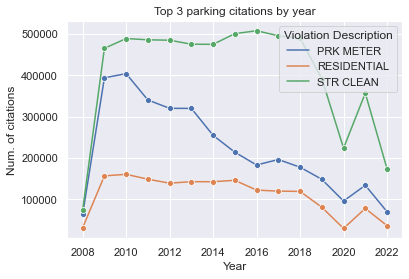

In [72]:
df_2 = citations[citations['Violation Description'].isin(types_of_cit)].copy()
df_2['year'] = df_2['Citation Issued DateTime'].dt.year
df_year = df_2[['Violation Description', 'year']].groupby('Violation Description').value_counts().reset_index()
sns.lineplot(x='year', y=0, hue='Violation Description', data=df_year, marker='o')
plt.xlabel('Year')
plt.ylabel('Num. of citations')
plt.title('Top 3 parking citations by year')

We notice that the overall number of parking citations are decreasing each year. However, for street cleaning citations, it seems to be that the number of street cleaning citations remains relative consistent (e.g. doesn't decrease) relative to the other top parking citations. This indicates that the probability of an individual getting a parking citation for street cleaning in 2022 is higher compared to other citations.

# Street specific trends

In [29]:
# Find the top 3 streets where citations occur
top_streets = citations['street_name'].value_counts()[:3].index

In [30]:
# Look at the top 3 violations per street, see if there are any differences
street_agg = citations[citations['street_name'].isin(top_streets)].groupby(['street_name', 'Violation Description']).agg({'Violation': 'count'})

top_3_viol_streets = street_agg['Violation'].groupby('street_name', group_keys=False).nlargest(3)
top_3_viol_streets

street_name    Violation Description
california st  PRK METER                 69615
               STR CLEAN                 50058
               RESIDENTIAL               15728
mission st     PRK METER                178813
               STR CLEAN                145712
               PRK PROHIB                47298
sacramento st  PRK METER                 74482
               STR CLEAN                 37026
               RESIDENTIAL               15143
Name: Violation, dtype: int64

Text(0.5, 1.0, 'Top 3 Streets with Parking Citations')

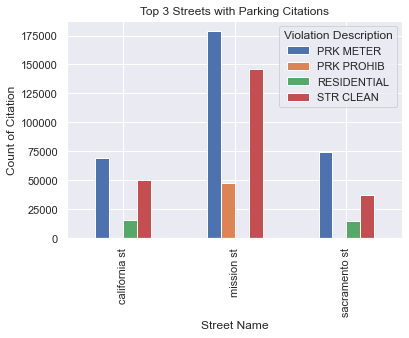

In [31]:
top_3_viol_streets.unstack(1).plot.bar()
plt.ylabel('Count of Citation')
plt.xlabel('Street Name')
plt.title('Top 3 Streets with Parking Citations')

In [32]:
# Potentially look into street-level trends for citations as in
# Do the times for major citations occur at different times for each street?
# Maybe do this later?

# Heatmap of the number of citations by neighborhood

In [33]:
neighborhood_counts = pd.DataFrame(citations['name'].value_counts()).reset_index()
neighborhood_counts = neighborhood_counts.rename(columns={'index': 'name', 'name': 'citation_count'})
neighborhood_counts

,name,citation_count
0,Showplace Square,921823
1,Potrero Hill,787278
2,Inner Sunset,460207
3,Lower Pacific Heights,427535
4,Civic Center,335366
...,...,...
111,Sunnydale,925
112,Mission Dolores,848
113,Outer Richmond,696
114,Westwood Park,562


In [34]:
from shapely import wkt
gpd_df = gpd.read_file('SFFind_Neighborhoods.csv')
gpd_df['the_geom'] = gpd.GeoSeries.from_wkt(gpd_df['the_geom'])
gpd_df = gpd_df.drop(columns = ['geometry', 'LINK'])
gpd_df = gpd_df.rename(columns={'the_geom':'geometry'})
gpd_df = gpd_df.merge(neighborhood_counts, left_on=['name'], right_on=['name']).set_index('name')


In [35]:
import plotly.express as px 

fig = px.choropleth(gpd_df, 
                    geojson=gpd_df.geometry, 
                    locations=gpd_df.index, 
                    color="citation_count",
                    height=500,
                   color_continuous_scale="sunsetdark")
                   
fig.update_geos(fitbounds="locations", visible=False)

fig.update_layout(
    title_text='Map of SF Citation Counts by Neighborhood'
)

fig.update(layout = dict(title=dict(x=0.5)))
fig.update_layout(
    margin={"r":0,"t":30,"l":10,"b":10},
    coloraxis_colorbar={
        'title':'Num. of citations'})

fig.show()

# Takeaways

- The 3 most common types of parking citations are street parking citations, parking meter citations, and residential parking citations.

- The neighborhoods with the most number of citations by a large margin are Showplace Square and Potrero Hill.

- When comparing the types of citations against one another, street cleaning citations varied compared to parking meter and residential citations, which followed a similar pattern.

- Most citations occur, on average, from 10-11 AM, peaking at around 12 for the most common types of citations. The exception to this is street cleaning, in which citations peak before and after 12. 

- The top 3 streets with most citations are (in no particular order) Mission Street, California Street, and Sacramento Street.

# Future considerations

- Find a better way to more accurately get street addresses and their respective locations to better analyze street-level trends.

- Create a dashboard that allows users to interact with the data more easily.

- Look into more interesting relationships between citations (e.g. Is there a correlation between street and hour of day where a specific citation occurs?, etc.)